In [119]:
using NCDatasets
using HDF5
using Plots
using DataFrames
using TypedTables
using DataFrames
using DecisionTree
using MLJ 
using GR
using ImageFiltering
#ImageFilter.jl for calculating the spatial features of radar dataset 

EarthRadiusKm = 6375.636
EarthRadiusSquare = 6375.636 * 6375.636

# Beamwidth of ELDORA and TDR
eff_beamwidth = 1.8
beamwidth = eff_beamwidth*0.017453292;

In [93]:
##Explore some datasets 
###Sweep is global dimension 
currset = Dataset("CFRADIALS/cfrad.19950516_222557.623_to_19950516_222559.999_TF-ELDR_AIR.nc")

Dataset: CFRADIALS/cfrad.19950516_222557.623_to_19950516_222559.999_TF-ELDR_AIR.nc
Group: /

Dimensions
   time = 221
   range = 384
   sweep = 1
   string_length_8 = 8
   string_length_32 = 32
   status_xml_length = 1
   r_calib = 1
   frequency = 4

Variables
  volume_number  
    Attributes:
     long_name            = data_volume_index_number
     units                = 
     _FillValue           = -9999

  platform_type   (32)
    Datatype:    Char (Char)
    Dimensions:  string_length_32
    Attributes:
     long_name            = platform_type
     options              = fixed, vehicle, ship, aircraft_fore, aircraft_aft, aircraft_tail, aircraft_belly, aircraft_roof, aircraft_nose, satellite_orbit, satellite_geostat

  primary_axis   (32)
    Datatype:    Char (Char)
    Dimensions:  string_length_32
    Attributes:
     long_name            = primary_axis_of_rotation
     options              = axis_z, axis_y, axis_x, axis_z_prime, axis_y_prime, axis_x_prime

  status_xml   (1)


In [98]:
plane_alts = currset["altitude"][:]
ray_angles = currset["elevation"][:]
azimuths = currset["azimuth"][:]
ranges = currset["range"][:]

384-element Vector{Float32}:
     0.0
   150.0
   300.0
   450.0
   600.0
   750.0
   900.0
  1050.0
  1200.0
  1350.0
  1500.0
  1650.0
  1800.0
     ⋮
 55800.0
 55950.0
 56100.0
 56250.0
 56400.0
 56550.0
 56700.0
 56850.0
 57000.0
 57150.0
 57300.0
 57450.0

In [102]:
max_range = maximum(ranges)

57450.0f0

In [110]:
deg2rad(90)

1.5707963267948966

In [111]:
    #Because the model was not trained on null data, this tells you where predictions need to be autoassigned


1.5707963267948966

In [103]:
####goes througha and for each gate calculates its height, 
####so is basically passing in a single gate's elevation, plane altitude
####azimuth, and range
####Slantrange is simply the range of the gate from the antenna, need to calculate its height then 

In [126]:
##Can be done on a ray-by-ray basis, otherwise the elevation angle will change 
##What is this algorithm? 
function airborne_ht(elevation_angle::Float64, antenna_range::Float64, aircraft_height::Float64)
    ##Initial heights are in meters, convert to km 
    aRange_km, acHeight_km = (antenna_range, aircraft_height) ./ 1000
    
    term1 = aRange_km^2 + EarthRadiusKm^2
    term2 = 2 * aRange_km * EarthRadiusKm * sin(deg2rad(elevation_angle))
    return sqrt(term1 + term2) - EarthRadiusKm + acHeight_km
end 


###How can we optimize this.... if one gate has a probability of ground equal to 1, the rest of 
###The gates further in that range must also have probability equal to 1, correct? 
function prob_groundgate(elevation_angle, antenna_range, aircraft_height, azimuth, max_range)
    
    ###If range of gate is less than altitude, cannot hit ground
    ###If elevation angle is positive, cannot hit ground 
    if (antenna_range > aircraft_height || elevation_angle > 0)
        return 0. 
    end 
    elevation_rad, azimuth_rad = map((x) -> deg2rad(x), (elevation_angle, azimuth))
    
    #Range at which the beam will intersect the ground (Testud et. al 1995 or 1999?)
    Earth_Rad_M = EarthRadiusKm*1000
    ground_intersect = (-(aircraft_height)/sin(elevation_rad))*(1+aircraft_height/(2*Earth_Rad_M* (tan(elevation_rad)^2)))
    
    range_diff = ground_intersect - antenna_range
    
    if (range_diff <= 0)
            return 1.
    end 
    
    gelev = asin(-aircraft_height/antenna_range)
    elevation_offset = elevation_rad - gelev
    
    if elevation_offset < 0
        return 1.
    else
        
        beamaxis = sqrt(elevation_offset * elevation_offset)
        gprob = exp(-0.69314718055995*(beamaxis/beamwidth))
        
        if (gprob>1.0)
            return 1.
        else
            return gprob
        end
    end 
end 

prob_groundgate (generic function with 1 method)

In [121]:
exp

exp (generic function with 18 methods)

In [68]:
###Get the DBZ data from a single scan 
###This is ASSUMING that this is not a npoints type file 
###If it is, possibly call radxconvert? 

JULIA_OFFSET = 1

SCAN = 1
start_idxs = currset["sweep_start_ray_index"]
end_idxs = currset["sweep_end_ray_index"]

###NOTE: JULIA is 1-INDEXED, so add OFFSET 
start_scan_idx = start_idxs[SCAN] + JULIA_OFFSET
end_scan_idx = end_idxs[SCAN] + JULIA_OFFSET

DBZ_currscan = currset["DBZ"][:,start_idxs[1]+1:1:end_idxs[1]+1]

##Need to remember to project range onto the elevation angle 
RANGE = currset["range"][:]
azimuth_angles = currset["azimuth"][start_idxs[1] + 1:1:end_idxs[1]+1]


##this is all WRONG because we're doing radars from a plane 
##Elevation angle of the current scan 
ELEV_ANGLE = currset["fixed_angle"][SCAN]
##Determine ground range 
GROUND_RANGE = map((x)-> x*cos(deg2rad(ELEV_ANGLE)), RANGE)
##Assuming no super/subrefraction 
###This is beam bottom height 
GATE_ELEVATION = map((x) -> x*sin(deg2rad(ELEV_ANGLE)), RANGE)

384-element Vector{Float32}:
     0.0
    42.175385
    84.35077
   126.52615
   168.70154
   210.87692
   253.0523
   295.2277
   337.40308
   379.57846
   421.75385
   463.92923
   506.1046
     ⋮
 15689.243
 15731.419
 15773.594
 15815.77
 15857.945
 15900.12
 15942.296
 15984.471
 16026.646
 16068.822
 16110.997
 16153.173

In [116]:
map((x) -> deg2rad(x), (1,2))

(0.017453292519943295, 0.03490658503988659)

In [80]:
function get_NCP(data::NCDataset)
    ###Some ternary operator + short circuit trickery here 
    ("NCP" in keys(data)) ? (return(data["NCP"][:,start_scan_idx:1:end_scan_idx])) : ("SQI" in keys(data) || 
                                                                                        error("Could Not Find NCP in dataset"))
    return(data["SQI"][:, start_scan_idx:1:end_scan_idx])
end

get_NCP (generic function with 3 methods)

In [79]:
currset["NCP"][:,:][:,1:1:221]

384×221 Matrix{Union{Missing, Float32}}:
 0.76      0.81      0.83      0.8       …  0.82      0.84      0.78
 0.62      0.61      0.63      0.69         0.55      0.58      0.42
 0.8       0.83      0.83      0.88         0.61      0.58      0.43
 0.27      0.42      0.33      0.37         0.33      0.27      0.32
 0.92      0.96      0.94      0.96         0.92      0.98      0.96
 0.93      0.95      0.96      0.95      …  0.95      0.93      0.94
 0.96      0.91      0.95      1.0          0.97      0.96      0.89
 0.93      0.95      0.99      0.96         0.97      0.95      0.91
 0.83      0.92      0.91      0.96         0.84      0.79      0.84
 0.91      0.97      0.95      1.0          0.62      0.69      0.5
 0.59      0.54      0.52      0.84      …  0.47      0.71      0.65
 0.44      0.71      0.33      0.72         0.46      0.4       0.47
 0.24      0.55      0.43      0.45         0.46      0.49      0.7
 ⋮                                       ⋱                      

In [63]:
[1 2 3][1:3]

3-element Vector{Int64}:
 1
 2
 3

In [19]:

##higher isolation parameter = more isolated 
##Check to see if Alex normalized this 

##Is there a smarter way to do this? Probably
##Probably create a parallel missing array and just window on this? 
##Benchmark this for optimization 
function isolation(var, weights)
    ##Returns 0 when missing, 1 when not 
    return sum(var .* weights)
end

iso_weights = ones(7,7)
iso_weights[4,4] = 0
avg_weights = ones(5,5)
avg_weights[3,3] = 0

##Testing function for timing 
##Why is the compilation time s
function calc_isolation_param(var, weights, window)
    
    if size(weights) != window
        error("Weight matrix does not equal window size")
    end
    
    missings = map((x) -> ismissing(x), var)
    iso_array = mapwindow((x) -> isolation(x, weights), missings, window) 
end

calc_isolation_param (generic function with 2 methods)

In [25]:
@time calc_isolation_param(DBZ_currscan, iso_weights, (7,7))

  0.021937 seconds (135.20 k allocations: 39.876 MiB, 23.62% gc time)


384×221 Matrix{Float64}:
 44.0  45.0  46.0  47.0  48.0  48.0  …  45.0  44.0  44.0  44.0  43.0  43.0
 37.0  38.0  39.0  40.0  41.0  41.0     38.0  37.0  37.0  37.0  37.0  37.0
 30.0  31.0  32.0  33.0  34.0  34.0     31.0  30.0  30.0  30.0  29.0  29.0
 24.0  24.0  25.0  26.0  27.0  27.0     24.0  24.0  23.0  23.0  22.0  22.0
 17.0  18.0  19.0  20.0  21.0  21.0     18.0  17.0  17.0  17.0  16.0  16.0
 10.0  11.0  12.0  13.0  14.0  14.0  …  12.0  12.0  13.0  13.0  13.0  14.0
  3.0   4.0   5.0   6.0   7.0   7.0      5.0   5.0   6.0   6.0   6.0   7.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  4.0   3.0   2.0   1.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  5.0   4.0   3.0   2.0   1.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  5.0   4.0   4.0   3.0   2.0   1.0      0.0   0.0   0.0   0.0   0.0   0.0
  5.0   5.0   5.0   4.0   3.0   1.0      1.0   1.0   1.0   1.0   0.0   0.0


In [22]:
@time mapwindow((x) -> isolation(x), DBZ_currscan, [1 1 1; 1 0 1; 1 1 1])

LoadError: entries in window must be odd, got (1, 1, 1, 1, 0, 1, 1, 1, 1)

In [26]:
###Possible to add in some superrefraction/subrefraction information here given geographic location? 
function probability_ground_gate(tilt, platform_height, azimuth, max-range)

LoadError: syntax: incomplete: premature end of input

In [39]:
toymatrix = [1 missing 1; 0 missing 0; 2 3 missing]

3×3 Matrix{Union{Missing, Int64}}:
 1   missing  1
 0   missing  0
 2  3          missing

In [131]:
toy_arr = Matrix([[missing,missing,1],[1,0,1],[1,3,4]])

LoadError: MethodError: no method matching (Matrix)(::Vector{Vector{Union{Missing, Int64}}})

[0mClosest candidates are:
[0m  (Array{T, N} where T)(::AbstractArray{S, N}) where {S, N}
[0m[90m   @[39m [90mCore[39m [90m[4mboot.jl:498[24m[39m
[0m  (Matrix)([91m::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY}[39m)
[0m[90m   @[39m [36mLinearAlgebra[39m [90m/Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/LinearAlgebra/src/[39m[90m[4mqr.jl:449[24m[39m
[0m  (Matrix)([91m::LinearAlgebra.Schur[39m)
[0m[90m   @[39m [36mLinearAlgebra[39m [90m/Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/LinearAlgebra/src/[39m[90m[4mschur.jl:437[24m[39m
[0m  ...


In [30]:
function test(weights::AbstractMatrix{Float64})
    return "OK"
end

test (generic function with 1 method)

In [32]:
test([1. 2. 3.])

"OK"

In [52]:
CartesianIndices(indind_full)

CartesianIndices((3, 3))

In [44]:
map(length, axes(toymatrix))

(3, 3)

In [53]:
_IndexTransformer

LoadError: UndefVarError: `_IndexTransformer` not defined

In [46]:
axes(toymatrix)

(Base.OneTo(3), Base.OneTo(3))

In [47]:
indind_full = map(r -> axes(r, 1), axes(toymatrix))

(Base.OneTo(3), Base.OneTo(3))

In [105]:
start_scan_idx = findmin(azimuth_angles)[2]

249

In [66]:
azimuth_angles[start_scan_idx:1:end]

112-element Vector{Union{Missing, Float32}}:
   0.02746582f0
   1.0519409f0
   1.9995117f0
   3.0596924f0
   4.040222f0
   5.072937f0
   6.0699463f0
   7.0092773f0
   8.02002f0
   9.0060425f0
  10.082703f0
  10.986328f0
  12.041016f0
   ⋮
 100.02777f0
 101.01105f0
 102.05475f0
 103.03528f0
 104.07623f0
 105.02106f0
 106.04004f0
 107.039795f0
 108.045044f0
 109.072266f0
 109.981384f0
 111.049805f0

In [80]:
polarheatmap(full_DBZ)

LoadError: TypeError: non-boolean (Missing) used in boolean context

In [20]:
begin_time = currset.attrib["start_time"]

"2008-04-11 18:22:30.747"

In [76]:
Set(currset["elevation"][:])

Set{Union{Missing, Float32}} with 145 elements:
  1.3513184f0
  1.2936401f0
  9.08844f0
  6.9625854f0
  8.047485f0
  1.2744141f0
  8.997803f0
  5.973816f0
  9.060974f0
  7.998047f0
  1.340332f0
  11.060486f0
  0.48339844f0
  11.071472f0
  5.987549f0
  4.9658203f0
  2.2521973f0
  11.030273f0
  3.9990234f0
  4.97406f0
  3.147583f0
  8.10791f0
  3.100891f0
  7.0806885f0
  2.194519f0
  ⋮ 

In [50]:
haskey(currset.dim, "sweep")

true

In [9]:
# But functions like mean, sum (and many more) would load every element 
# individually which is very inefficient for large fields read from disk.
#     You should instead convert such a variable to a standard Julia Array and then
# #     do computations with it. See also the performance tips for more information.
# Reading data from a file is not type-stable, because the type of the output of the read 
# operation is dependent on the type defined in the NetCDF files and the value of 
# various attribute (like scale_factor, add_offset and units for time conversion). 
# All this information cannot be inferred from a static analysis of the source code. 
# It is therefore recommended to use type annotation if the resulting type of a read operation in known:

360.0

In [50]:

###Hyperparameters from paper: 21 trees, max depth 14
currmodel = DecisionTree.RandomForestClassifier(;n_trees=21, max_depth=14)
###Determine the class weights 

RandomForestClassifier
n_trees:             21
n_subfeatures:       -1
partial_sampling:    0.7
max_depth:           14
min_samples_leaf:    1
min_samples_split:   2
min_purity_increase: 0.0
classes:             nothing
ensemble:            nothing

In [29]:
training_frac = .72
validation_frac = .08 
testing_frac = 1 - training_frac + validation_frac 

0.36000000000000004

In [15]:
filepath = "./data/raw_Vortex.h5"
currset = HDF5.h5open(filepath)
x = currset["X"]
y = currset["Y"]

n_features = size(x)[2]
n_outputs = size(y)[1]

12878391

In [16]:
###Convert HDFS data into a dataframe 
X_DF = DataFrames.DataFrame(x[:,:], :auto)
Y_DF = DataFrames.DataFrame(reshape(y[:],(n_outputs, 1)), :auto)

Row,x1
,Int64
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [38]:
###Partition the data accordingly 
(training_x, testing_x), (training_y, testing_y) = partition((X_DF, Y_DF), (training_frac + validation_frac), multi=true)
(training_x, validation_x), (training_y, validation_y) = partition((training_x, training_y), 
                                                        training_frac/(training_frac + validation_frac), multi=true )

((9272442×14 DataFrame
     Row │ x1       x2       x3       x4        x5            x6            x7 ⋯
         │ Float64  Float64  Float64  Float64   Float64       Float64       Fl ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │   -7.6    -34.99     0.83   1358.94      -8.636         7.24533     ⋯
       2 │   -7.71    10.5      0.92   1431.68      -8.91842       8.93789
       3 │   -9.06    18.5      0.94   1507.07      -9.03609      11.7696
       4 │   -9.6     25.13     0.97   1584.99      -9.05296      13.7578
       5 │  -10.12    25.75     0.98   1665.38      -9.2037       22.8863      ⋯
       6 │   -9.27    27.25     0.98   1748.14      -9.27296      24.7196
       7 │   -9.04    26.13     0.96   1833.19      -9.2263       25.3489
       8 │   -7.8     25.38     0.96   1920.43      -9.19481      24.9322
       9 │   -7.1     23.0      0.95   2009.79      -9.24185      23.9789      ⋯
      10 │   -8.41    20.38     0.96   2101.2 

In [45]:
total = nrow(training_x) + nrow(validation_x) + nrow(testing_x)

12878391

In [66]:
(endtime-starttime)/60

9.252876734733581

In [62]:
starttime = time()
fit!(currmodel, x[:,:], y[:])
endtime = time() 

1.698872595271028e9

In [18]:
results = predict(currmodel,x[:,:])

12878391-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [21]:
nwrong = sum(abs.(results - y[:]))

169782

In [22]:
nwrong / length(y)

0.01318347920947578

In [13]:
?RandomForestClassifier

search: RandomForestClassifier



```
RandomForestClassifier(; n_subfeatures::Int=-1,
                       n_trees::Int=10,
                       partial_sampling::Float=0.7,
                       max_depth::Int=-1,
                       rng=Random.GLOBAL_RNG,
                       impurity_importance::Bool=true)
```

Random forest classification. See [DecisionTree.jl's documentation](https://github.com/bensadeghi/DecisionTree.jl)

Hyperparameters:

  * `n_subfeatures`: number of features to consider at random per split (default: -1, sqrt(# features))
  * `n_trees`: number of trees to train (default: 10)
  * `partial_sampling`: fraction of samples to train each tree on (default: 0.7)
  * `max_depth`: maximum depth of the decision trees (default: no maximum)
  * `min_samples_leaf`: the minimum number of samples each leaf needs to have
  * `min_samples_split`: the minimum number of samples in needed for a split
  * `min_purity_increase`: minimum purity needed for a split
  * `rng`: the random number generator to use. Can be an `Int`, which will be used to seed and create a new random number generator. Multi-threaded forests must be seeded with an `Int`
  * `impurity_importance`: whether to calculate feature importances using `Mean Decrease in Impurity (MDI)`. See [`DecisionTree.impurity_importance`](@ref)

Implements `fit!`, `predict`, `predict_proba`, `get_classes`


In [133]:
MLJ.fit_data_scitype(default_model)

Tuple{Table{<:Union{AbstractVector{<:Count}, AbstractVector{<:Continuous}}}, AbstractVector{<:Finite}}

In [64]:
##Grab the model and instantiate a base version of it
RFC = @load RandomForestClassifier pkg=MLJScikitLearnInterface
default_model = RFC(n_estimators=14)

import MLJScikitLearnInterface ✔


[ Info: For silent loading, specify `verbosity=0`. 


RandomForestClassifier(
  n_estimators = 14, 
  criterion = "gini", 
  max_depth = nothing, 
  min_samples_split = 2, 
  min_samples_leaf = 1, 
  min_weight_fraction_leaf = 0.0, 
  max_features = "sqrt", 
  max_leaf_nodes = nothing, 
  min_impurity_decrease = 0.0, 
  bootstrap = true, 
  oob_score = false, 
  n_jobs = nothing, 
  random_state = nothing, 
  verbose = 0, 
  warm_start = false, 
  class_weight = nothing, 
  ccp_alpha = 0.0, 
  max_samples = nothing)

In [158]:
evaluate(default_model, X_DF, Y_DF) 

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJScikitLearnInterface.RandomForestClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{AbstractVector{Continuous}}, Table{AbstractVector{Count}}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:Union{AbstractVector{<:Count}, AbstractVector{<:Continuous}}}, AbstractVector{<:Finite}}
└ @ MLJBase ~/.julia/packages/MLJBase/fEiP2/src/machines.jl:2

LoadError: ArgumentError: 
observation scitype of target = `AbstractVector{Count}` but (LogLoss(tol = 2.22045e-16)) only supports `Union{Missing, Infinite, Finite}`.
To override measure checks, set check_measure=false. 

In [138]:
scitype(Y_DF)

Table{AbstractVector{Count}}

In [156]:
Vector<:AbstractVector

true

In [155]:
y[:]<:Union{AbstractVector{<:Count}, AbstractVector{<:Continuous}}

LoadError: TypeError: in <:, expected Type, got a value of type Vector{Int64}

In [63]:
@doc MLJScikitLearnInterface.RandomForestClassifier

```
RandomForestClassifier
```

A model type for constructing a random forest classifier, based on [MLJScikitLearnInterface.jl](https://github.com/JuliaAI/MLJScikitLearnInterface.jl), and implementing the MLJ model interface.

From MLJ, the type can be imported using

```
RandomForestClassifier = @load RandomForestClassifier pkg=MLJScikitLearnInterface
```

Do `model = RandomForestClassifier()` to construct an instance with default hyper-parameters. Provide keyword arguments to override hyper-parameter defaults, as in `RandomForestClassifier(n_estimators=...)`.

A random forest is a meta estimator that fits a number of  classifying decision trees on various sub-samples of the  dataset and uses averaging to improve the predictive accuracy  and control over-fitting. The sub-sample size is controlled  with the `max_samples` parameter if `bootstrap=True` (default),  otherwise the whole dataset is used to build each tree.


In [71]:
 MLJ.fit_data_scitype(default_model)

Tuple{Table{<:Union{AbstractVector{<:Count}, AbstractVector{<:Continuous}}}, AbstractVector{<:Finite}}

In [47]:
function calc_std(ds)
    return 
end 


function mine_cfradial(filepath)
    ##Open cfradial file using netcdf 
    currset = Dataset(filepath)
    return


LoadError: syntax: incomplete: "function" at In[47]:6 requires end

In [49]:
function mine_cfradial(filepath)
    ##Open cfradial file using netcdf 
    currset = Dataset(filepath)
    return
end

mine_cfradial (generic function with 1 method)

In [87]:
Table(name=[1,2,3,4,5], test=[1,0,0,1,1])

LoadError: MethodError: no method matching Table(; name::Vector{Int64}, test::Vector{Int64})

[0mClosest candidates are:
[0m  Table([91m::Type...[39m)[91m got unsupported keyword arguments "name", "test"[39m
[0m[90m   @[39m [35mScientificTypesBase[39m [90m~/.julia/packages/ScientificTypesBase/N7myy/src/[39m[90m[4mScientificTypesBase.jl:107[24m[39m


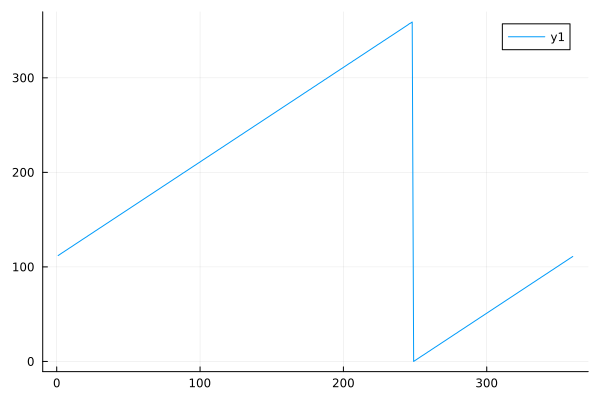

In [22]:
plot(currset["azimuth"][start_idxs[1]+1:1:end_idxs[1]+1])

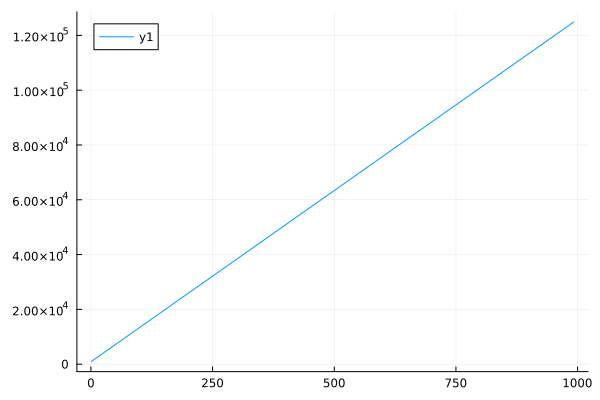

In [24]:
plot(currset["range"][:])

In [139]:
currset["DBZ"]

DBZ (384 × 87)
  Datatype:    Union{Missing, Float32} (Int16)
  Dimensions:  range × time
  Attributes:
   long_name            = Radar Reflectivity Factor, Combined
   units                = dBZ
   sampling_ratio       = 1.0
   _FillValue           = -32768
   scale_factor         = 0.01
   add_offset           = -0.0
   grid_mapping         = grid_mapping
   coordinates          = time range


In [123]:
.!(map(ismissing, DBZ_RAW))

384×87 BitMatrix:
 0  0  1  0  0  0  0  0  1  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  0  0  1  1  1  1  1  1  0  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  0  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  0  0  1  1     0  

In [ ]:
#Let's only plot the values for which #ismissing is 0 

In [127]:
vals = DBZ_RAW[.!map(ismissing, DBZ_RAW)]
##Need to map azimuths and ranges onto the same shape array 
azis = currset["azimuth"]
ranges = currset["range"]

range (384)
  Datatype:    Float32 (Float32)
  Dimensions:  range
  Attributes:
   long_name            = Range from instrument to center of gate
   units                = meters
   spacing_is_constant  = true
   meters_to_center_of_first_gate = 0.0
   meters_between_gates = 150.00000596046448


In [75]:
minimum(currset["azimuth"][:])

226.82762f0

In [4]:
eval(:log10)

log10 (generic function with 8 methods)

In [71]:
currset["range"][:]

384-element Vector{Float32}:
     0.0
   150.0
   300.0
   450.0
   600.0
   750.0
   900.0
  1050.0
  1200.0
  1350.0
  1500.0
  1650.0
  1800.0
     ⋮
 55800.0
 55950.0
 56100.0
 56250.0
 56400.0
 56550.0
 56700.0
 56850.0
 57000.0
 57150.0
 57300.0
 57450.0